# NLP - Crossword Puzzles
**Tony Ghabour**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#NLP---Crossword-Puzzles" data-toc-modified-id="NLP---Crossword-Puzzles-1">NLP - Crossword Puzzles</a></span></li><li><span><a href="#Initial-Setup" data-toc-modified-id="Initial-Setup-2">Initial Setup</a></span></li><li><span><a href="#Data-Work" data-toc-modified-id="Data-Work-3">Data Work</a></span><ul class="toc-item"><li><span><a href="#Retreival" data-toc-modified-id="Retreival-3.1">Retreival</a></span></li><li><span><a href="#Store-in-MongoDB" data-toc-modified-id="Store-in-MongoDB-3.2">Store in MongoDB</a></span></li><li><span><a href="#Retreive-from-MongoDB" data-toc-modified-id="Retreive-from-MongoDB-3.3">Retreive from MongoDB</a></span></li><li><span><a href="#Processing" data-toc-modified-id="Processing-3.4">Processing</a></span></li></ul></li><li><span><a href="#Puzzle-Class/Objects" data-toc-modified-id="Puzzle-Class/Objects-4">Puzzle Class/Objects</a></span><ul class="toc-item"><li><span><a href="#Grids-(Heatmaps)" data-toc-modified-id="Grids-(Heatmaps)-4.1">Grids (Heatmaps)</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-5">EDA</a></span><ul class="toc-item"><li><span><a href="#Answers" data-toc-modified-id="Answers-5.1">Answers</a></span></li><li><span><a href="#Clues" data-toc-modified-id="Clues-5.2">Clues</a></span></li></ul></li><li><span><a href="#NLP-Analysis" data-toc-modified-id="NLP-Analysis-6">NLP Analysis</a></span><ul class="toc-item"><li><span><a href="#Dimensionality-Reduction" data-toc-modified-id="Dimensionality-Reduction-6.1">Dimensionality Reduction</a></span><ul class="toc-item"><li><span><a href="#Vectorize-Corpus" data-toc-modified-id="Vectorize-Corpus-6.1.1">Vectorize Corpus</a></span></li><li><span><a href="#LSA" data-toc-modified-id="LSA-6.1.2">LSA</a></span><ul class="toc-item"><li><span><a href="#Count" data-toc-modified-id="Count-6.1.2.1">Count</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-6.1.2.2">TF-IDF</a></span></li></ul></li><li><span><a href="#NMF" data-toc-modified-id="NMF-6.1.3">NMF</a></span><ul class="toc-item"><li><span><a href="#Count" data-toc-modified-id="Count-6.1.3.1">Count</a></span></li><li><span><a href="#TF-IDF" data-toc-modified-id="TF-IDF-6.1.3.2">TF-IDF</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-7">Classification</a></span></li><li><span><a href="#Future-Work" data-toc-modified-id="Future-Work-8">Future Work</a></span></li></ul></div>

# Initial Setup

In [1]:
import sys
sys.path.append('../src')

In [2]:
#Standard Libraries 
import os
import re
import ast
import xword
import json
import random 
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import statistics as st
import matplotlib.pyplot as plt

from string import digits
from datetime import datetime 
from collections import Counter 
from matplotlib.ticker import PercentFormatter

%matplotlib inline 

In [3]:
# Database management 
from pymongo import MongoClient

In [4]:
# NLP & Text Processing
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [5]:
# Classification Model Tools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Data Work

## Retreival

In [6]:
all_puzzles = []
base_path = '../data/raw/'
puzzle_paths = xword.get_jsons(base_path)

for json_file_path in puzzle_paths:
    with open(json_file_path) as json_file:
        try:
            all_puzzles.append(json.load(json_file))
        except:
            print(f'Unable to load puzzle: {json_file_path}')
            pass

Unable to load puzzle: ../data/raw/2017/12/03.json
Unable to load puzzle: ../data/raw/2018/03/08.json


## Store in MongoDB

In [7]:
client = MongoClient()

In [8]:
db = client.NYT

In [9]:
#db.create_collection("puzzle_collection") # only run once 
db.list_collection_names()

['puzzle_collection']

In [10]:
pc = db.get_collection("puzzle_collection")

In [11]:
#pc.insert_many(all_puzzles) # only run once 

In [12]:
len(all_puzzles), pc.count_documents({})

(14545, 14545)

## Retreive from MongoDB

In [13]:
projection = {'_id': 0, 
              'acrossmap': 0, 
              'admin': 0, 
              'autowrap': 0,
              'bbars': 0,
              'code': 0, 
              'copyright': 0,
              'rbars': 0, 
              'track': 0, 
              'downmap': 0, 
              'mini': 0, 
              'key': 0, 
              'id': 0, 
              'id2': 0,
              'interpretcolors': 0,   
              'hold': 0,
              'publisher': 0, 
              'uniclue' : 0,
              'valid': 0,
              'type': 0}

filter_ = {'uniclue': {"$ne": True}}

cursor = pc.find(filter_,projection)

In [14]:
pc_df = pd.DataFrame(list(cursor))

In [15]:
pc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14544 entries, 0 to 14543
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   answers       14544 non-null  object
 1   author        14544 non-null  object
 2   circles       346 non-null    object
 3   clues         14544 non-null  object
 4   date          14544 non-null  object
 5   dow           14544 non-null  object
 6   editor        14544 non-null  object
 7   grid          14544 non-null  object
 8   gridnums      14544 non-null  object
 9   jnotes        503 non-null    object
 10  notepad       202 non-null    object
 11  shadecircles  59 non-null     object
 12  size          14544 non-null  object
 13  title         14544 non-null  object
 14  hastitle      473 non-null    object
dtypes: object(15)
memory usage: 1.7+ MB


## Processing

In [16]:
# Create fields in dataframe for number of rows and columns in each crossword puzzle
pc_df['rows'] = pc_df['size'].apply(lambda x: x['rows'])
pc_df['cols'] = pc_df['size'].apply(lambda x: x['cols'])

# Aggregate down+accross clues and answers in separate fields
pc_df['all_clues'] = pc_df['clues'].apply(lambda x: x['across'] + x['down']) 
pc_df['all_answers'] = pc_df['answers'].apply(lambda x: x['across'] + x['down']) 

# Clean up redundant data
pc_df = pc_df.drop(['size', 
                    'clues', 
                    'answers'], axis = 1)

In [17]:
pc_df['clean_clues'] = pc_df['all_clues'].apply(lambda x: xword.process_text(x))
pc_df['clean_answers'] = pc_df['all_answers'].apply(lambda x: xword.process_text(x))

In [18]:
pc_df.to_csv('../data/processed/cleaned_corpus.csv')

# Puzzle Class/Objects

**Specify date range over which to retrieve/inspect puzzles.**

In [19]:
start_date = dt.date(2000, 1, 1)
end_date = dt.date(2004, 1, 1)
dt_range = xword.date_range(start_date, end_date)

In [20]:
list_of_puzzles = xword.get_puzzles(dt_range)
puzzle_count = len(list_of_puzzles)
random_index = random.choice(range(puzzle_count))

In [21]:
sample_puzzle = xword.puzzle()
sample_puzzle.parse_puzzle(list_of_puzzles[random_index])

**Now we can use our class to drill down and investigate attributes of an individual puzzle or group of puzzles.**

In [22]:
sample_puzzle.date, sample_puzzle.dow

('10/24/2000', 'Tuesday')

In [23]:
sample_puzzle.author

'Alan Arbesfeld'

In [24]:
sample_puzzle.editor

'Will Shortz'

In [25]:
sample_puzzle.clues.across

['1. Choreographer Ailey',
 '6. Highchair feature',
 '10. Love handles, essentially',
 '14. Capital near 0° latitude',
 '15. All-knowing',
 '16. See red',
 '17. Kind of renewal',
 '18. Letters from Athens',
 '19. Halo, e.g.',
 '20. White House nickname',
 '21. Underground commuter',
 '24. Resting on',
 '25. Was restless',
 "26. One who'll give you fits",
 '29. Oft-impersonated one',
 "31. Speaker's woe",
 '33. Pal for Pierre',
 '36. "Rag Mop" singers the ___ Brothers',
 '37. Popular card game',
 '38. It can be cast',
 '39. Curtain holder',
 '40. Cause of erosion, maybe',
 '44. Upholstery fabric',
 "45. Outflow's opposite",
 "46. Stuff one's face",
 '49. Snack in a stack',
 '50. Prepare to do some barbering',
 '53. Write quickly',
 '56. It falls hard',
 '57. Verne hero',
 '58. Hose shade',
 '60. Downwind, nautically',
 '61. Privy to',
 '62. Book end?',
 '63. Popular Microsoft software',
 '64. "New" drink of the 80\'s',
 '65. Bond, for one']

In [26]:
sample_puzzle.clues.down

['1. Here, in Seville',
 '2. Hang around unobserved',
 '3. Sensation, slangily',
 '4. Call ___ day',
 '5. 24/7',
 '6. Pipsqueak',
 '7. Singer Coolidge',
 '8. Pronto',
 '9. Where the Talmud is studied',
 "10. They're circulated in Paris",
 '11. Roll in the aisles',
 '12. Go along (with)',
 '13. Santa Claus feature',
 '22. Lawsuit basis',
 '23. Arguing',
 '24. Pub pints',
 '26. Abdicator of 1917',
 '27. Spheric opening?',
 '28. Really steamed',
 '29. "Sesame Street" regular',
 '30. Aerial maneuver',
 '32. Be a pitcher',
 "33. Diva's delivery",
 '34. Lama, e.g.',
 '35. "Bus Stop" playwright',
 '38. Enthusiastic about',
 '40. Progresso product',
 '41. 1912 headline name',
 '42. Dali contemporary',
 '43. Sluggishness',
 '44. Drove, slangily',
 '46. "Oh, come on!"',
 '47. Author Calvino',
 '48. "Jackie Brown" actress Pam',
 '49. Layer with a hole in it',
 '51. Where people split',
 '52. In a frenzy',
 '53. Penultimate book of the Bible',
 '54. Big tournament',
 '55. Teleprompter filler',
 '5

In [27]:
sample_puzzle.answers.across

['ALVIN',
 'TRAY',
 'FLAB',
 'QUITO',
 'WISE',
 'RAGE',
 'URBAN',
 'ETAS',
 'AURA',
 'IKE',
 'STRAPHANGER',
 'ATOP',
 'ITCHED',
 'TAILOR',
 'ELVIS',
 'STREPTHROAT',
 'AMI',
 'AMES',
 'UNO',
 'IRON',
 'ROD',
 'STRIPMINING',
 'TOILE',
 'INTAKE',
 'PIGOUT',
 'OREO',
 'STROPARAZOR',
 'JOT',
 'HAIL',
 'NEMO',
 'TAUPE',
 'ALEE',
 'INON',
 'INDEX',
 'WORD',
 'COKE',
 'AGENT']

In [28]:
sample_puzzle.answers.down

['AQUI',
 'LURK',
 'VIBE',
 'ITA',
 'NONSTOP',
 'TWERP',
 'RITA',
 'ASAP',
 'YESHIVA',
 'FRANCS',
 'LAUGH',
 'AGREE',
 'BEARD',
 'TORT',
 'ATIT',
 'ALES',
 'TSAR',
 'ATMO',
 'IRED',
 'ERNIE',
 'LOOP',
 'HURL',
 'ARIA',
 'MONK',
 'INGE',
 'INTO',
 'SOUP',
 'TITANIC',
 'MIRO',
 'INERTIA',
 'TOOLED',
 'PSHAW',
 'ITALO',
 'GRIER',
 'OZONE',
 'RENO',
 'AMOK',
 'JUDE',
 'OPEN',
 'TEXT',
 'ANG']

In [29]:
sample_puzzle.blank()


**NY TIMES, TUE, OCT 24, 2000**

[_|_|_|_|_|■|_|_|_|_|■|_|_|_|_]
[_|_|_|_|_|■|_|_|_|_|■|_|_|_|_]
[_|_|_|_|_|■|_|_|_|_|■|_|_|_|_]
[_|_|_|■|_|_|_|_|_|_|_|_|_|_|_]
[■|■|■|_|_|_|_|■|■|_|_|_|_|_|_]
[_|_|_|_|_|_|■|_|_|_|_|_|■|■|■]
[_|_|_|_|_|_|_|_|_|_|_|■|_|_|_]
[_|_|_|_|■|■|_|_|_|■|■|_|_|_|_]
[_|_|_|■|_|_|_|_|_|_|_|_|_|_|_]
[■|■|■|_|_|_|_|_|■|_|_|_|_|_|_]
[_|_|_|_|_|_|■|■|_|_|_|_|■|■|■]
[_|_|_|_|_|_|_|_|_|_|_|■|_|_|_]
[_|_|_|_|■|_|_|_|_|■|_|_|_|_|_]
[_|_|_|_|■|_|_|_|_|■|_|_|_|_|_]
[_|_|_|_|■|_|_|_|_|■|_|_|_|_|_]


In [30]:
sample_puzzle.solution()


**NY TIMES, TUE, OCT 24, 2000**

[A L V I N ■ T R A Y ■ F L A B]
[Q U I T O ■ W I S E ■ R A G E]
[U R B A N ■ E T A S ■ A U R A]
[I K E ■ S T R A P H A N G E R]
[■ ■ ■ A T O P ■ ■ I T C H E D]
[T A I L O R ■ E L V I S ■ ■ ■]
[S T R E P T H R O A T ■ A M I]
[A M E S ■ ■ U N O ■ ■ I R O N]
[R O D ■ S T R I P M I N I N G]
[■ ■ ■ T O I L E ■ I N T A K E]
[P I G O U T ■ ■ O R E O ■ ■ ■]
[S T R O P A R A Z O R ■ J O T]
[H A I L ■ N E M O ■ T A U P E]
[A L E E ■ I N O N ■ I N D E X]
[W O R D ■ C O K E ■ A G E N T]


## Grids (Heatmaps)

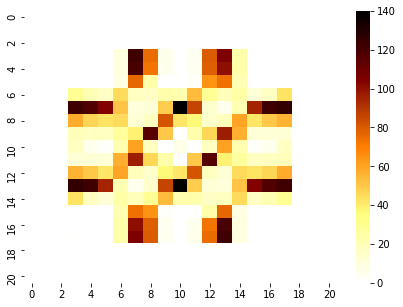

In [31]:
xword.heat_map(list_of_puzzles, days = ['Monday'])

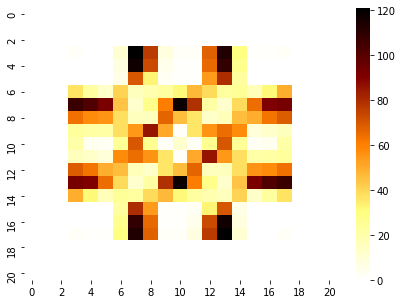

In [32]:
xword.heat_map(list_of_puzzles, days = ['Tuesday'])

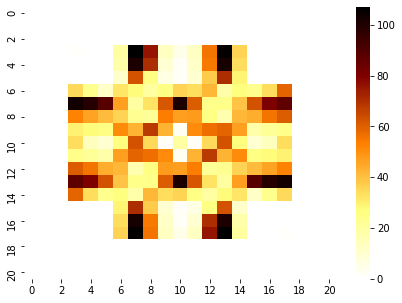

In [33]:
xword.heat_map(list_of_puzzles, days = ['Wednesday'])

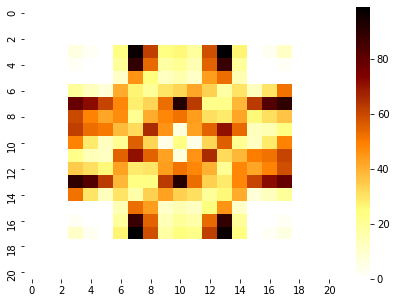

In [34]:
xword.heat_map(list_of_puzzles, days = ['Thursday'])

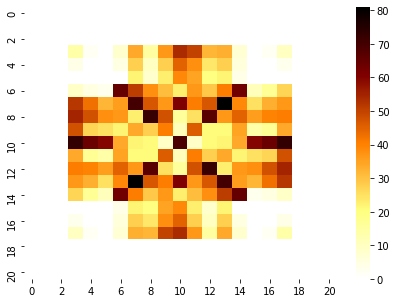

In [35]:
xword.heat_map(list_of_puzzles, days = ['Friday'])

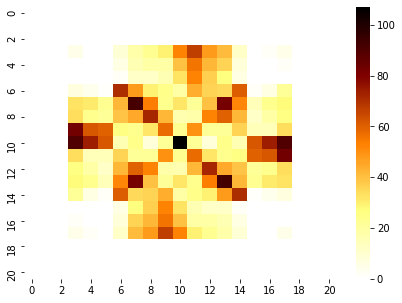

In [36]:
xword.heat_map(list_of_puzzles, days = ['Saturday'])

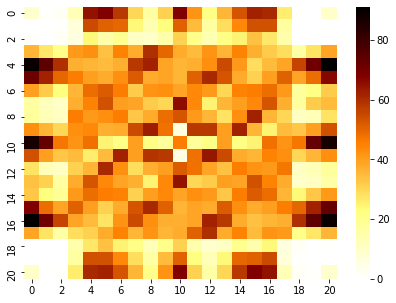

In [37]:
xword.heat_map(list_of_puzzles, days = ['Sunday'])

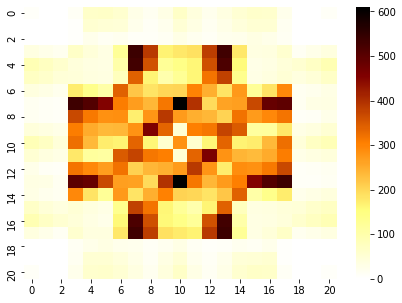

In [38]:
xword.heat_map(list_of_puzzles, days = 'all')

# EDA

**Pull in clean data.**

In [39]:
pc_df = pd.read_csv('../data/processed/cleaned_corpus.csv')
pc_df = pc_df.drop(['Unnamed: 0'], axis = 1)

In [40]:
pc_df['all_clues'] = pc_df['all_clues'].apply(lambda x: ast.literal_eval(x))
pc_df['all_answers'] = pc_df['all_answers'].apply(lambda x: ast.literal_eval(x))

#
pc_df['clean_clues'] = pc_df['clean_clues'].apply(lambda x: xword.reduce_col(x))
pc_df['clean_answers'] = pc_df['clean_answers'].apply(lambda x: xword.reduce_col(x))

**Total number of puzzles in corpus.**

In [41]:
len(pc_df)

14544

**Count number of unique authors.**

In [42]:
pc_df.author.nunique()

1716

## Answers

**Let's take a look at the answers...specifically, statistics relating to answer lengths and novelty/uniqueness.**

In [43]:
pc_df['ans_lens'] = pc_df['all_answers'].apply(lambda x: [len(y) for y in x])
pc_df['min_len'] = pc_df['ans_lens'].apply(lambda x: min(x))
pc_df['max_len'] = pc_df['ans_lens'].apply(lambda x: max(x))
pc_df['mean_len'] = pc_df['ans_lens'].apply(lambda x: st.mean(x))
pc_df['median_len'] = pc_df['ans_lens'].apply(lambda x: st.median(x))

In [44]:
pc_df.describe()

,rows,cols,min_len,max_len,mean_len,median_len
count,14544.000000,14544.000000,14544.000000,14544.000000,14544.000000,14544.000000
mean,15.910272,15.911235,3.009832,13.126306,5.108109,4.517774
std,2.249449,2.248846,0.107989,3.004443,0.328575,0.573106
min,9.000000,13.000000,1.000000,6.000000,4.186047,3.000000
25%,15.000000,15.000000,3.000000,11.000000,4.846154,4.000000
50%,15.000000,15.000000,3.000000,14.000000,5.026316,4.000000
75%,15.000000,15.000000,3.000000,15.000000,5.285714,5.000000
max,29.000000,31.000000,6.000000,50.000000,7.192308,7.000000


In [45]:
answer_df = pc_df.set_index(['date'])

In [46]:
answers_only = (pd.melt(answer_df.all_answers.apply(pd.Series).reset_index(), 
                id_vars=['date'], 
                value_name='all_answers')
               .set_index(['date'])
               .drop('variable', axis=1)
               .dropna()
               .sort_index()
              ).reset_index()

answers_only = answers_only.sort_values(['date'])

In [47]:
answers = set()
new_ans_dates = []
for idx, row in answers_only.iterrows():
    if row[1] in answers:
        pass
    else:
        new_ans_dates.append(row.date)
        answers.add(row[1])
        
new_ans = Counter()
for date in new_ans_dates: 
    new_ans[date] += 1

In [48]:
answers_df = pd.DataFrame.from_dict(new_ans, orient='index').reset_index()
answers_df = answers_df.rename({0:'unique_ans_count', 'index': 'date'}, axis = 1)

In [49]:
answers_df['date_dt'] = answers_df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').date())
answers_df['dow_int'] = answers_df.date_dt.apply(lambda x: x.weekday()) 

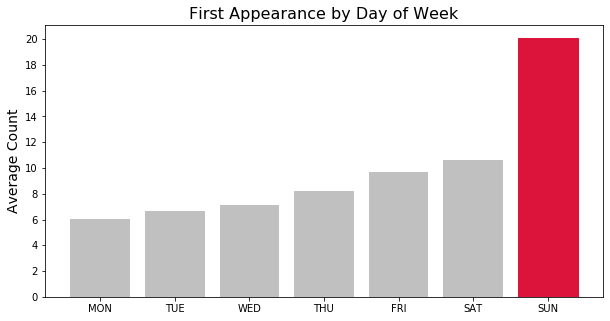

In [50]:
plot_data = answers_df.groupby(['dow_int']).mean().reset_index()
dow_labels = ('MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN')

x = plot_data['dow_int']
y = plot_data['unique_ans_count']

plt.figure(figsize=(10,5))
plt.xticks(range(7), dow_labels)
plt.yticks(np.arange(0, 25, step=2))

plt.ylabel('Average Count', size = 14)

bars = plt.bar(x, y, color='silver');
bars[6].set_color('crimson')

plt.title('First Appearance by Day of Week', size = 16);

plt.savefig("../img/avg_unique_words.svg", format="svg")

## Clues

In [51]:
pc_df['fillin_pct'] = pc_df.all_clues.apply(lambda x: xword.fillin_pct(x))
pc_df['quotes_pct'] = pc_df.all_clues.apply(lambda x: xword.quotes_pct(x))
pc_df['ques_pct'] = pc_df.all_clues.apply(lambda x: xword.ques_pct(x))
pc_df['self_ref'] = pc_df.all_clues.apply(lambda x: xword.self_ref(x))

In [52]:
pc_df['date_dt'] = pc_df['date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y').date())
pc_df['dow_int'] = pc_df.date_dt.apply(lambda x: x.weekday()) 

In [53]:
plot_data = pc_df.groupby(['dow_int']).mean().reset_index() #.drop(['rows', 'cols'], axis = 1)
plot_data

,dow_int,rows,cols,min_len,max_len,mean_len,median_len,fillin_pct,quotes_pct,ques_pct,self_ref
0,0,14.997605,15.006705,3.006705,12.812739,4.869408,4.194923,0.082352,0.076684,0.010132,0.008855
1,1,15.000960,15.006721,3.013442,12.748920,4.891678,4.209794,0.078958,0.078304,0.017631,0.011078
2,2,15.003359,15.005758,3.010077,12.880518,4.925756,4.280710,0.073889,0.078352,0.024450,0.012296
3,3,15.006767,15.009183,3.004350,12.905752,5.044950,4.438376,0.076596,0.078223,0.028624,0.013414
4,4,15.004344,15.000965,3.013031,12.318533,5.347068,4.776303,0.067984,0.078692,0.032739,0.009569
5,5,15.004817,15.000482,3.021676,11.966281,5.413265,4.910886,0.063803,0.075578,0.032976,0.009298
6,6,21.371622,21.366313,2.999517,16.259170,5.268005,4.818050,0.073457,0.080435,0.040728,0.008578


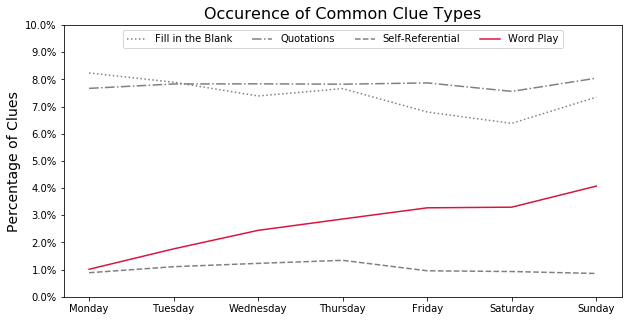

In [54]:
dow_labels = ('Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday')

plt.figure(figsize=(10,5))
plt.xticks(range(7), dow_labels)

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

plt.plot(plot_data['dow_int'], plot_data['fillin_pct'], alpha = 1, linestyle=':', color = 'grey')
plt.plot(plot_data['dow_int'], plot_data['quotes_pct'], alpha = 1, linestyle='-.', color = 'grey')
plt.plot(plot_data['dow_int'], plot_data['self_ref'], alpha = 1, linestyle='--', color = 'grey')
plt.plot(plot_data['dow_int'], plot_data['ques_pct'], color = 'crimson');

plt.title('Occurence of Common Clue Types', size = 16)
plt.ylabel('Percentage of Clues', size = 14)
plt.yticks(np.arange(0, .11, step=.01))
plt.legend(['Fill in the Blank', 'Quotations', 'Self-Referential', 'Word Play'], loc='upper center', ncol=4);

plt.savefig("../img/clue_types.svg", format="svg")

# NLP Analysis

In [55]:
docs = pc_df['clean_clues']
docs.head()

0    leave altar stop rain hit movie abbr whoop gan...
1    increase intensity high hatter wear totally pl...
2    game figure soldier bed fish dish real estate ...
3    polite response thank classic verse begin brok...
4    side effect steroid use handoff isnt biblical ...
Name: clean_clues, dtype: object

## Dimensionality Reduction

In [56]:
topics = 50

### Vectorize Corpus

**Count Vectorizer**

In [57]:
cv = CountVectorizer(ngram_range = (2,3), stop_words = 'english', min_df = .0002) #, max_df = .0005
#cv = CountVectorizer(ngram_range = (2,2), stop_words = 'english', min_df = .0002) #, max_df = .0005

In [58]:
doc_word_cv = cv.fit_transform(docs)
pd.DataFrame(doc_word_cv.toarray(), index=list(docs.index), columns=cv.get_feature_names()).head()

,aaa abbr,aaa baseball,aaa baseball team,aaa concern,aaa map,aaa offering,aaa recommendation,aaa recommendation abbr,aaa suggestion,aachen abode,...,zoroastrian sacred,zoroastrian scripture,zorro mark,zsa sister,zsa zsa,zulu warrior,zwei drei,zwei follower,zwei vier,zygomatic muscle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**TF-IDF Vectorizer**

In [59]:
tf = TfidfVectorizer(ngram_range = (2,3), stop_words = 'english', min_df = .0002) #, max_df = .0005)

In [60]:
doc_word_tf = tf.fit_transform(docs)
pd.DataFrame(doc_word_tf.toarray(), index=list(docs.index), columns=tf.get_feature_names()).head()

,aaa abbr,aaa baseball,aaa baseball team,aaa concern,aaa map,aaa offering,aaa recommendation,aaa recommendation abbr,aaa suggestion,aachen abode,...,zoroastrian sacred,zoroastrian scripture,zorro mark,zsa sister,zsa zsa,zulu warrior,zwei drei,zwei follower,zwei vier,zygomatic muscle
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### LSA

In [61]:
lsa = TruncatedSVD(topics)

#### Count 

In [62]:
vectorizer = cv

In [63]:
doc_topic_lsa_cv = lsa.fit_transform(doc_word_cv)
sum(lsa.explained_variance_ratio_)

0.028184157912073873

In [64]:
topic_word_lsa_cv = pd.DataFrame(lsa.components_.round(3),
                                 index = [f'component_{i}' for i in range(topics)],
                                 columns = vectorizer.get_feature_names())
topic_word_lsa_cv.head()

,aaa abbr,aaa baseball,aaa baseball team,aaa concern,aaa map,aaa offering,aaa recommendation,aaa recommendation abbr,aaa suggestion,aachen abode,...,zoroastrian sacred,zoroastrian scripture,zorro mark,zsa sister,zsa zsa,zulu warrior,zwei drei,zwei follower,zwei vier,zygomatic muscle
component_0,0.000,0.000,0.000,0.001,0.001,0.000,0.000,0.000,0.001,0.0,...,0.0,0.0,0.000,0.000,0.002,0.0,0.001,0.002,0.0,0.0
component_1,0.001,0.001,0.001,0.000,-0.000,0.002,0.002,0.001,0.002,0.0,...,0.0,0.0,0.001,0.001,0.001,0.0,0.001,0.000,0.0,0.0
component_2,-0.001,0.000,0.000,-0.000,-0.000,-0.000,-0.002,-0.001,-0.001,-0.0,...,-0.0,-0.0,-0.000,-0.000,-0.001,-0.0,0.001,-0.001,-0.0,-0.0
component_3,0.000,0.001,0.001,-0.000,-0.000,-0.002,0.003,0.001,0.001,-0.0,...,-0.0,-0.0,-0.000,-0.000,-0.001,-0.0,-0.000,-0.002,-0.0,-0.0
component_4,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,0.000,0.000,0.0,...,0.0,0.0,0.000,0.000,0.000,0.0,-0.000,-0.000,-0.0,0.0


In [65]:
xword.display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
comb form, greek letter, card game, bone comb form, bone comb, new york, old style, chemical suffix, north sea, long time

Topic  1
new york, slang ily, long time, title role, old style, hall famer, white house, oscar winner, star war, hall fame

Topic  2
new york, york city, new york city, comb form, york island, new york island, new york new, york new, york governor, new york governor

Topic  3
slang ily, comb form, mouth slang ily, mouth slang, card game, ice cream, coffee slang ily, new york, coffee slang, slang ily like

Topic  4
step quote, end step, start step, end step quote, start step quote, author step, author step quote, quote iii, step quote iii, quote source

Topic  5
long time, slang ily, step quote, comb form, new york, long long, long long time, new york city, york city, end step quote

Topic  6
title role, hall famer, comb form, football hall, football hall famer, baseball hall, baseball hall famer, oscar winner, hall fame, star war

Topic  7
hall famer, bas

In [66]:
Vt_cv = pd.DataFrame(doc_topic_lsa_cv.round(5),
                     index = list(docs.index),
                     columns =  [f'component_{i}' for i in range(topics)])
Vt_cv.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,0.03460,0.21277,-0.07122,-0.02817,-0.00141,-0.02566,0.01690,-0.00758,0.01931,0.07244,...,-0.19004,-0.30086,0.04738,0.14650,0.11693,-0.04289,-0.20748,0.06011,0.10098,0.05555
1,0.06276,0.42690,-0.18456,-0.11048,0.03257,-0.28361,0.41339,1.08546,0.10661,0.11720,...,0.04699,0.35864,-0.15067,-0.07837,-0.22590,0.05745,-0.03052,0.24668,0.09763,0.09224
2,0.04482,0.17444,-0.06949,-0.03269,0.02137,-0.06876,-0.00770,-0.00687,0.00936,0.04648,...,-0.14585,-0.09906,-0.15915,0.03288,-0.14166,-0.06242,0.15882,-0.09669,0.04287,0.06169
3,0.12527,0.53242,-0.17995,-0.05780,0.04864,-0.30103,0.08779,-0.12012,0.02062,0.12789,...,0.15149,0.42034,-0.46786,-0.61722,-0.08906,-0.08586,0.45570,0.03585,0.30593,0.11732
4,0.06249,0.30223,-0.16250,-0.01557,0.04699,-0.18798,0.12152,-0.29851,0.87769,-0.05597,...,-0.02605,0.05114,-0.09461,0.02019,-0.04850,0.07814,0.14898,0.15697,0.02801,-0.15796


#### TF-IDF 

In [67]:
vectorizer = tf

In [68]:
doc_topic_lsa_tf = lsa.fit_transform(doc_word_tf)
sum(lsa.explained_variance_ratio_)

0.011870248618298421

In [69]:
topic_word_lsa_tf = pd.DataFrame(lsa.components_.round(3),
                                 index = [f'component_{i}' for i in range(topics)],
                                 columns = vectorizer.get_feature_names())
topic_word_lsa_tf.head()

,aaa abbr,aaa baseball,aaa baseball team,aaa concern,aaa map,aaa offering,aaa recommendation,aaa recommendation abbr,aaa suggestion,aachen abode,...,zoroastrian sacred,zoroastrian scripture,zorro mark,zsa sister,zsa zsa,zulu warrior,zwei drei,zwei follower,zwei vier,zygomatic muscle
component_0,0.001,0.001,0.001,0.001,0.003,0.001,0.001,0.001,0.002,0.001,...,0.001,0.001,0.001,0.001,0.006,0.001,0.001,0.003,0.001,0.001
component_1,-0.002,-0.002,-0.002,0.001,0.003,-0.002,-0.002,-0.001,-0.001,-0.001,...,0.001,-0.001,-0.000,-0.001,0.003,0.001,-0.001,0.003,0.000,-0.001
component_2,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.001,-0.000,-0.000,0.000,...,0.000,0.001,0.003,0.000,0.004,-0.000,-0.001,-0.000,0.001,-0.000
component_3,-0.001,0.001,0.001,-0.001,-0.001,0.000,-0.001,-0.000,0.000,-0.001,...,-0.001,-0.001,0.003,-0.001,0.003,-0.000,0.001,-0.001,-0.000,-0.000
component_4,-0.001,-0.000,-0.001,-0.000,0.000,0.001,-0.002,-0.001,-0.003,0.000,...,0.001,-0.000,-0.003,0.000,-0.003,0.000,0.001,0.001,0.001,-0.000


In [70]:
xword.display_topics(lsa, vectorizer.get_feature_names(), 10)


Topic  0
comb form, greek letter, new york, long time, slang ily, card game, old style, oscar winner, chemical suffix, north sea

Topic  1
comb form, bone comb form, bone comb, wine comb form, wine comb, air comb, air comb form, greek letter, mountain comb form, mountain comb

Topic  2
greek letter, north sea, sea feeder, north sea feeder, chemical suffix, card game, river north sea, river north, french coin, old french

Topic  3
new york, north sea, sea feeder, north sea feeder, york city, new york city, river north, river north sea, york island, new york island

Topic  4
new york, greek letter, york city, new york city, chemical suffix, sea bird, card game, hebrew letter, song dom, lake city

Topic  5
hall famer, baseball hall, baseball hall famer, football hall, football hall famer, greek letter, hall fame, long time, baseball hall fame, nfl hall

Topic  6
long time, long long, long long time, step quote, greek letter, new york, york city, new york city, chemical suffix, right hand

In [71]:
Vt_tf = pd.DataFrame(doc_topic_lsa_tf.round(5),
                     index = list(docs.index),
                     columns =  [f'component_{i}' for i in range(topics)])
Vt_tf.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,0.01804,-0.02273,-0.00931,-0.00706,-0.00933,-0.00448,0.00080,0.00162,0.00184,-0.00364,...,-0.01139,0.00726,0.01198,0.00428,0.01186,0.00124,-0.00724,0.00528,0.00774,-0.00729
1,0.03064,-0.03871,-0.01501,-0.00655,-0.03390,0.11960,-0.03969,0.00676,0.01224,0.01123,...,-0.04922,-0.00108,0.00370,-0.03992,-0.01425,-0.01755,0.01778,-0.01283,-0.01437,0.00798
2,0.02096,-0.01698,-0.00074,-0.00196,-0.00271,-0.00066,-0.00365,0.00229,-0.00256,0.00369,...,0.01714,0.00816,0.00018,-0.01371,-0.00672,0.00827,-0.00696,0.00200,0.01142,-0.00648
3,0.03488,-0.03423,-0.00904,-0.01077,-0.00842,-0.00810,-0.01597,0.00319,-0.00529,-0.00859,...,0.00275,-0.01858,0.01302,0.00051,-0.01301,0.02278,-0.01000,-0.00912,0.00319,-0.00589
4,0.02225,-0.02488,-0.00871,-0.01063,-0.01306,-0.01646,-0.01544,0.01413,-0.00550,-0.00094,...,0.00727,0.00218,0.00371,-0.00500,-0.01875,0.00547,-0.01148,0.00109,0.01415,-0.00528


### NMF

In [72]:
nmf_model = NMF(topics)

#### Count

In [73]:
vectorizer = cv

In [74]:
doc_topic_nmf_cv = nmf_model.fit_transform(doc_word_cv)

In [75]:
topic_word_nmf_cv = pd.DataFrame(nmf_model.components_.round(3),
                                 index = [f'component_{i}' for i in range(topics)],
                                 columns = vectorizer.get_feature_names())
topic_word_nmf_cv.head()

,aaa abbr,aaa baseball,aaa baseball team,aaa concern,aaa map,aaa offering,aaa recommendation,aaa recommendation abbr,aaa suggestion,aachen abode,...,zoroastrian sacred,zoroastrian scripture,zorro mark,zsa sister,zsa zsa,zulu warrior,zwei drei,zwei follower,zwei vier,zygomatic muscle
component_0,0.000,0.000,0.000,0.007,0.009,0.000,0.000,0.000,0.003,0.000,...,0.001,0.000,0.00,0.0,0.012,0.001,0.003,0.016,0.001,0.0
component_1,0.000,0.000,0.000,0.028,0.052,0.002,0.000,0.000,0.000,0.012,...,0.043,0.009,0.03,0.0,0.037,0.032,0.000,0.040,0.028,0.0
component_2,0.000,0.006,0.006,0.000,0.000,0.006,0.000,0.000,0.000,0.000,...,0.000,0.000,0.00,0.0,0.000,0.000,0.005,0.000,0.000,0.0
component_3,0.004,0.005,0.004,0.000,0.000,0.000,0.018,0.006,0.004,0.000,...,0.000,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.0
component_4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.0


In [76]:
xword.display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
comb form, bone comb form, bone comb, wine comb form, wine comb, air comb, air comb form, mountain comb form, mountain comb, mar comb

Topic  1
song dom, hebrew letter, jewish month, sea bird, chemical compound, italian wine, electrical unit, pulitzer prize, compass point, food fish

Topic  2
new york, new york island, york island, york governor, new york governor, new york new, york new, york new york, new york canal, york canal

Topic  3
slang ily, mouth slang ily, mouth slang, record label, land abbr, coffee slang ily, coffee slang, abbr like, slogan eer, film director

Topic  4
step quote, start step, end step, end step quote, start step quote, author step, author step quote, quote iii, step quote iii, quote source

Topic  5
long time, long long, long long time, record label, time abbr, long time nbc, time nbc, century year, mark card, news man

Topic  6
title role, peter fonda, fonda title role, fonda title, peter fonda title, richard gere, grammy winner, attorney genera

In [77]:
H_cv = pd.DataFrame(doc_topic_nmf_cv.round(5),
                    index = list(docs.index),
                    columns =  [f'component_{i}' for i in range(topics)])
H_cv.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,0.0,0.0,0.00000,0.00446,0.00000,0.00444,0.00000,0.00000,0.00000,0.00000,...,0.0,0.00000,0.00321,0.00262,0.00028,0.00616,0.00000,0.00000,0.00000,0.00019
1,0.0,0.0,0.00000,0.00000,0.00204,0.00000,0.00000,0.25527,0.00000,0.00000,...,0.0,0.00000,0.00000,0.00078,0.00000,0.00415,0.00014,0.00000,0.00369,0.00000
2,0.0,0.0,0.00000,0.00000,0.00000,0.00158,0.00000,0.00192,0.00000,0.00016,...,0.0,0.00527,0.00000,0.00233,0.00000,0.00000,0.00115,0.00259,0.00034,0.00000
3,0.0,0.0,0.00331,0.00739,0.00000,0.00000,0.00284,0.00607,0.00236,0.00000,...,0.0,0.03544,0.00746,0.00398,0.02592,0.00000,0.00000,0.02491,0.00235,0.00000
4,0.0,0.0,0.00000,0.00000,0.00337,0.00000,0.00000,0.00000,0.19740,0.00000,...,0.0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


#### TF-IDF 

In [78]:
vectorizer = tf

In [79]:
doc_topic_nmf_tf = nmf_model.fit_transform(doc_word_tf)

In [80]:
topic_word_nmf_tf = pd.DataFrame(nmf_model.components_.round(3),
                                 index = [f'component_{i}' for i in range(topics)],
                                 columns = vectorizer.get_feature_names())
topic_word_nmf_tf.head()

,aaa abbr,aaa baseball,aaa baseball team,aaa concern,aaa map,aaa offering,aaa recommendation,aaa recommendation abbr,aaa suggestion,aachen abode,...,zoroastrian sacred,zoroastrian scripture,zorro mark,zsa sister,zsa zsa,zulu warrior,zwei drei,zwei follower,zwei vier,zygomatic muscle
component_0,0.000,0.000,0.000,0.009,0.009,0.000,0.000,0.000,0.007,0.000,...,0.004,0.000,0.000,0.000,0.020,0.006,0.003,0.021,0.001,0.00
component_1,0.011,0.005,0.004,0.000,0.000,0.000,0.015,0.003,0.004,0.004,...,0.000,0.014,0.000,0.004,0.000,0.003,0.004,0.000,0.001,0.02
component_2,0.000,0.000,0.000,0.003,0.006,0.000,0.000,0.000,0.000,0.000,...,0.011,0.003,0.005,0.000,0.015,0.007,0.000,0.002,0.014,0.00
component_3,0.000,0.002,0.002,0.000,0.000,0.002,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.000,0.00
component_4,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.000,...,0.000,0.000,0.011,0.000,0.014,0.000,0.000,0.000,0.000,0.00


In [81]:
xword.display_topics(nmf_model, vectorizer.get_feature_names(), 10)


Topic  0
comb form, bone comb form, bone comb, wine comb form, wine comb, air comb form, air comb, egg comb, egg comb form, mountain comb

Topic  1
city near, star trek, old fashioned, title character, pulitzer winning, wall street, largest city, gold medalist, old time, star trek tng

Topic  2
compass point, jewish month, food fish, chemical compound, sea bird, song dom, wading bird, sea eagle, electrical unit, hebrew letter

Topic  3
new york, york city, new york city, upstate new, upstate new york, york island, new york island, york new, new york new, york new york

Topic  4
north sea, sea feeder, north sea feeder, river north sea, river north, said tom, baltic sea feeder, baltic sea, division word, sleigh puller

Topic  5
hall famer, baseball hall, baseball hall famer, football hall, football hall famer, nfl hall famer, nfl hall, basketball hall famer, famer comb, hall famer comb

Topic  6
long time, long long, long long time, long time nbc, time nbc, time abbr, long time chicago,

In [82]:
H_tf = pd.DataFrame(doc_topic_nmf_tf.round(5),
                    index = list(docs.index),
                    columns =  [f'component_{i}' for i in range(topics)])
H_tf.head()

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,...,component_40,component_41,component_42,component_43,component_44,component_45,component_46,component_47,component_48,component_49
0,0.0,0.00190,0.0,0.0000,0.00000,0.00000,0.00156,0.00000,0.00026,0.0,...,0.00235,0.0,0.00000,0.0,0.0000,0.0000,0.00000,0.0,0.00000,0.00000
1,0.0,0.00000,0.0,0.0000,0.00000,0.08718,0.00000,0.00000,0.00000,0.0,...,0.00000,0.0,0.00000,0.0,0.0000,0.0045,0.00000,0.0,0.00000,0.00290
2,0.0,0.00139,0.0,0.0003,0.00005,0.00014,0.00000,0.00000,0.00000,0.0,...,0.00000,0.0,0.00000,0.0,0.0000,0.0000,0.00090,0.0,0.00000,0.00000
3,0.0,0.01589,0.0,0.0000,0.00000,0.00000,0.00000,0.00000,0.00000,0.0,...,0.00000,0.0,0.00136,0.0,0.0002,0.0000,0.00489,0.0,0.00921,0.00021
4,0.0,0.00781,0.0,0.0000,0.00000,0.00000,0.00000,0.00078,0.00000,0.0,...,0.00000,0.0,0.00000,0.0,0.0000,0.0000,0.00000,0.0,0.00000,0.00000


# Classification

In [83]:
lr = LogisticRegression(max_iter = 1000, multi_class = 'multinomial')

In [84]:
all_features = Vt_cv.merge(pc_df[['fillin_pct', 'quotes_pct', 'ques_pct', 'self_ref']], 
                           how ='inner', 
                           left_index = True, 
                           right_index = True)

In [85]:
X_1 = Vt_cv
X_2 = all_features
y = pc_df.dow

In [86]:
model_data_1 = train_test_split(X_1, y, test_size=0.3, random_state=420)
model_data_2 = train_test_split(X_2, y, test_size=0.3, random_state=420)

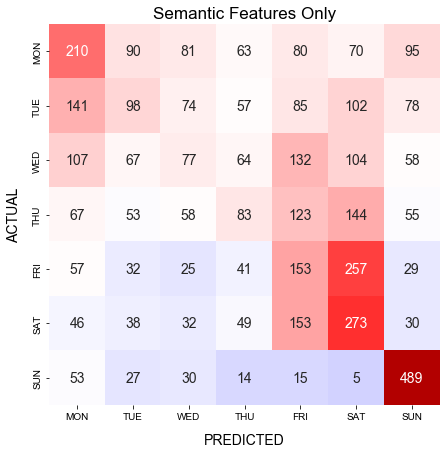

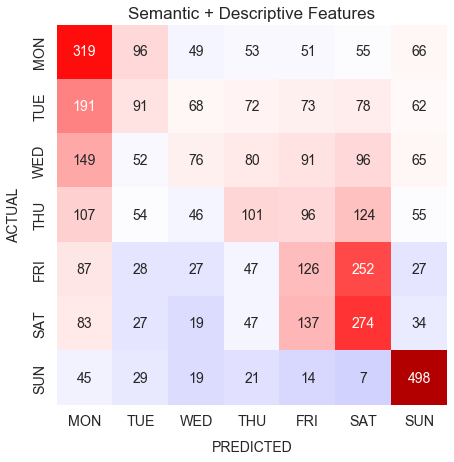

In [87]:
xword.show_cm(lr, model_data_1, colormap = 'seismic', title = "Semantic Features Only")
xword.show_cm(lr, model_data_2, colormap = 'seismic', title = "Semantic + Descriptive Features")  

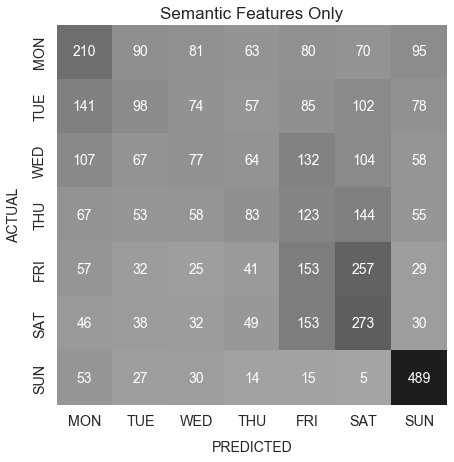

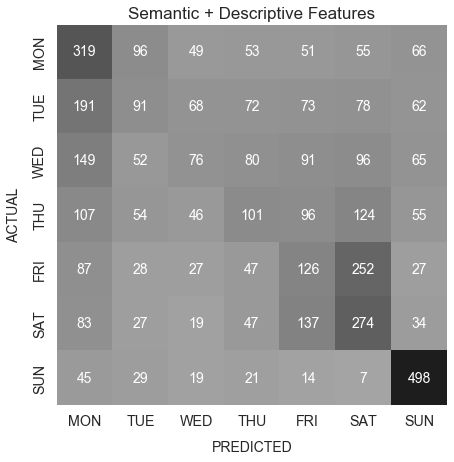

In [88]:
xword.show_cm(lr, model_data_1, colormap = 'Greys', title = "Semantic Features Only")
xword.show_cm(lr, model_data_2, colormap = 'Greys', title = "Semantic + Descriptive Features")  

# Future Work

* Letter frequency
* Answer length
* Named entity recognition 
* Analysis by author
* Analysis by editor
* Changes over time 
* Refined topic analysis
* Consider using individual clues as docs
* Clustering
* Try other classifiers and ensembling (Naive Bayes?)
* LDA?